In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os 
import re

import urllib.request
import h5py
import gzip
import pickle

import preprocessing
import util_worm as util

import matplotlib.pyplot as plt
from itertools import combinations,product

In [2]:
# FTP directory
ftp_path='ftp://ftp.mrc-lmb.cam.ac.uk/pub/tjucikas/wormdatabase/results-12-06-08/Laura%20Grundy/gene_NA/allele_NA/'

In [3]:
# Download data from ftps server
dir_dataraw = 'data/raw'
dir_datastore='data/results'

In [4]:
# List worms
worm_files = np.load(os.path.join(dir_dataraw,'N2_nine_worms.npz'))['files']

In [5]:
# Download worm files
for line in worm_files:
    src_path = os.path.join(ftp_path, line)
    dest_path = os.path.join(dir_dataraw,line)
    if os.path.exists(dest_path):
        print('File exists\n{}\n'.format(dest_path))
    else:
        print('File "%s" is not in memory\n'%line)
        tmp_ = os.path.join(dir_dataraw,os.path.dirname(line))
        if not os.path.exists(tmp_):
            print('Creating directory\n')
            os.makedirs(tmp_)
        print("Downloading to %s"%dest_path)
        urllib.request.urlretrieve(src_path, dest_path)

File exists
data/raw/N2/on_food/XX/30m_wait/R/tracker_3/2010-11-04___11_16_00/N2 on food L_2010_11_04__11_16___3___3_features.mat

File exists
data/raw/N2/on_food/XX/30m_wait/R/tracker_3/2010-10-15___11_45_00/N2 on food L_2010_10_15__11_45___3___3_features.mat

File exists
data/raw/N2/on_food/XX/30m_wait/R/tracker_2/2011-04-13___11_19_12/N2 on food L_2011_04_13__11_19_12___2___3_features.mat

File exists
data/raw/N2/on_food/XX/30m_wait/R/tracker_2/2011-03-24___12_42_49/N2 on food_2011_03_24__12_42_49___2___2_features.mat

File exists
data/raw/N2/on_food/XX/30m_wait/R/tracker_2/2010-10-15___14_57_14/N2 on food L_2010_10_15__14_57_14___2___8_features.mat

File exists
data/raw/N2/on_food/XX/30m_wait/R/tracker_2/2010-10-15___13_03_39/N2 on food L_2010_10_15__13_03_39___2___7_features.mat

File exists
data/raw/N2/on_food/XX/30m_wait/R/tracker_2/2010-10-15___12_25_23/N2 on food L_2010_10_15__12_25_23___2___5_features.mat

File exists
data/raw/N2/on_food/XX/30m_wait/R/tracker_2/2010-10-15___1

In [6]:
# directory to store data
fout = os.path.join(dir_datastore,'extracted_aus_N2.npz')
if not os.path.isfile(fout):
    aus , lens = [], []
    for ii , worm_file in enumerate(worm_files):
        fname_in = os.path.join(dir_dataraw, worm_file)
        fname_out = os.path.join(dir_datastore,
                                 re.sub('/','--',worm_file.strip())[:-4])
        os.makedirs(fname_out)
        print('Processing %s'%(fname_in))
        au =  preprocessing.extract_worm(fname_in,fname_out)
        aus.append(au)
        lens.append(au.shape[1])
    np.savez(fout,aus=np.concatenate(aus,axis=1),
             worm_files=worm_files,
             time_frames=lens)
else:
    print('File "%s" exits'%fout)

File "data/results/extracted_aus_N2.npz" exits


In [7]:
def make_joint_aus(worm_files,dir_datastore):
    """
    Combine activity of selected worms
    """
    fout_eig = os.path.join(dir_datastore,'joint_eigAmps_N2.npz')
    fout_aus = os.path.join(dir_datastore,'joint_aus_N2.npz')
    
    if os.path.exists(fout_aus):
        aus = np.asarray(np.load(fout_aus)['aus'])
        eigvec_all = np.load(fout_aus)['eigvecs']
        dims = aus.shape
        aus = aus.reshape((np.prod(dims[:2]),-1))
        return aus, eigvec_all
    
    fname_pdata = 'pdata.npz'
    all_angleArray= [np.load(os.path.join(dir_datastore,
                                          re.sub('/', '--',worm_file[:-4]),
                                          fname_pdata))['angleArray'] 
                     for worm_file in worm_files]

    # force angles to have same length
    common_ = min([np.shape(x)[0] for x in all_angleArray])
    time_frames = [common_]*len(worm_files)
    locations = np.cumsum(time_frames[:-1])
    worms_angleArray = [angle[:common_,:] for angle in all_angleArray]
    worms_angleArray = np.vstack(worms_angleArray)
    eigval_all, eigvec_all = preprocessing.worm_covariance(worms_angleArray)
    eigAmps = np.dot(eigvec_all.T,worms_angleArray.T)
    eigAmps_list = np.hsplit(eigAmps,locations)
    np.savez(fout_eig,eigAmps=eigAmps_list,
         worm_files=worm_files,
         time_frames=time_frames)

    au = util.eig_normalization(eigAmps)
    au_list = np.hsplit(au,locations)

    np.savez(fout_aus, aus=au_list,
             worm_files=worm_files,
             time_frames=time_frames,
             eigvecs=eigvec_all)
    return au, eigvec_all 

In [8]:
def fig1a_pc(eigvec_all):
    """
    plot eigvecs
    """
    num_eigs , num_pts = eigvec_all.shape
    num_eigs=4
    s = np.linspace(0,1,num_pts)
    fig, axarr = plt.subplots(num_eigs,1,figsize=(4,8))
    for ii in range(num_eigs):
        axarr[ii].plot(s,eigvec_all[:,ii],'k')
        axarr[ii].plot(s,np.zeros(num_pts),'r-')
        axarr[ii].plot(np.zeros(num_pts),
                       np.linspace(-0.05,0.2,num_pts),'r-')
        axarr[ii].set_axis_off()
    plt.show()
    return

In [9]:
def fig1a_jd(au):
    """
    Plot joint pd of au values
    """
    from matplotlib import rc, rcParams
    import matplotlib
    from mpl_toolkits.axes_grid1 import AxesGrid
    plt.rc('text', usetex=True)
    plt.rc('font', family='times')
    rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
    matplotlib.rcParams.update({'font.size': 10})
       
    fig = plt.figure(figsize=(4, 6))
    grid = AxesGrid(fig, 111,
                direction='column',
                nrows_ncols=(3, 2),
                axes_pad=0.55,
                share_all=False,
                label_mode=all,
                cbar_location='bottom',
                cbar_mode='single',
                cbar_pad=0.00,
                )

    bins = np.linspace(-2, 2, 101)
    tick_vals= np.linspace(-2,2,3)

    for index, pairs in enumerate(combinations(np.arange(4),2)):
        pc1, pc2 = pairs    
        H, _, _= np.histogram2d(au[pc1],au[pc2],
                                normed=True,bins=bins)
        ax = grid[index] 
        img = ax.imshow(H, interpolation='nearest', 
                        clim=(0.0, 0.3) , 
                        extent=[-2, 2, -2, 2] ,
                        cmap='Reds',vmin=0,vmax=0.3)
        ax.set_xticks(tick_vals)
        ax.set_yticks(tick_vals)
        ax.set_xticklabels(map(str,tick_vals))
        ax.set_yticklabels(map(str,tick_vals))
        ax.set_aspect('equal')
        ax.set_xlabel(r'$a_{%d}$'%(pc1+1))
        ax.set_ylabel(r'$a_{%d}$'%(pc2+1))
    cbar = grid.cbar_axes[0].colorbar(img)
    cbar.ax.set_xticks(np.linspace(0,0.3,3))
    
    plt.subplots_adjust(hspace=0.3)
    plt.show()
    #plt.savefig('figures/all_aus_reds.eps')
    return

In [10]:
au, eigvec_all= make_joint_aus(worm_files,dir_datastore)

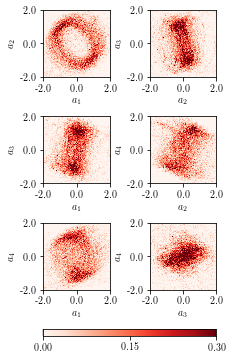

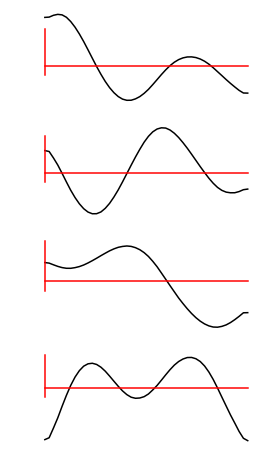

In [11]:
fig1a_jd(au)
fig1a_pc(eigvec_all)

In [12]:
from collections import namedtuple

Results = namedtuple( "Results", 
                     ["name", "loglikes", "predictive_lls",
                      "predictive_lls2","N_used", "alphas",
                      "gammas","samples", "timestamps"])

def load_batch_results(fdir,attribute,worm_array,
                       state_array,alpha_array,gamma_array,kappa_array):
    cresults =[]
    for worm , num_states, alpha_a_0, gamma_a_0, kappa_a_0 in product(
        worm_array, state_array,alpha_array,gamma_array,kappa_array):
        fname = "ar_scale_worm%s_states%s_alpha%s_gamma%s_kappa%s"%(
            worm,"%.1f" %num_states, "%.1f" %alpha_a_0, "%.1f" %gamma_a_0,
            "%.1f" %kappa_a_0)
        results_file = os.path.join(fdir,fname + ".pkl.gz")
        with gzip.open(results_file, "r") as f:
            results = pickle.load(f)
            out = getattr(results,attribute)
            if not (attribute =='samples'):
                cresults.append(np.asarray(out))
            else:
                cresults.append(out)
    if not (attribute =='samples'):
        cresults = np.asarray(cresults)
    return cresults

In [13]:
experiments_out = os.path.join(dir_datastore,'run010')
worm_files_ = [re.sub('/', '--',worm_file[:-4]) for worm_file in worm_files]
fname_pdata = 'pdata.npz'

In [14]:
# Load info from each worm
all_angleArray= [np.load(os.path.join(
    dir_datastore,worm_file,fname_pdata))['angleArray'] 
                 for worm_file in worm_files_]
all_meanAngle= [np.load(os.path.join(
    dir_datastore,worm_file,fname_pdata))['meanAngles'] 
                 for worm_file in worm_files_]
all_x= [np.load(os.path.join(
    dir_datastore,worm_file,fname_pdata))['x'] 
                 for worm_file in worm_files_]
all_y= [np.load(os.path.join(
    dir_datastore,worm_file,fname_pdata))['y'] 
                 for worm_file in worm_files_]

In [15]:
def fig1a_plane(x,y,tf=4500):
    plt.plot(x[0,:],y[0,:],'k')
    plt.plot(x[0,tf],y[0,tf],'ro',ms=10)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    return
#plt.savefig('figures/worm_xyplot.eps', format='eps',orientation='portrait',papertype='letter')

def fig1a_cworm(x,tf=4500):
    plt.plot(x[tf],'k',lw=3)
    plt.plot(x[tf,0],'ro')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    return
#plt.savefig('figures/worm_angleArray.eps', format='eps',orientation='portrait',papertype='letter')

In [16]:
worm_idx = 1

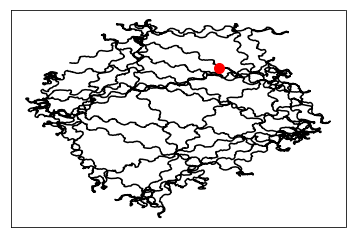

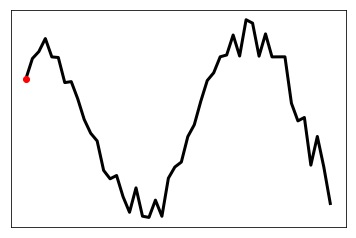

In [17]:
aa = all_x[worm_idx]
bb = all_y[worm_idx]
cc = all_angleArray[worm_idx]
fig1a_plane(aa,bb)
fig1a_cworm(cc)

In [18]:
import matplotlib
from matplotlib import rc, rcParams
plt.rc('text', usetex=True)
plt.rc('font', family='times')
rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
matplotlib.rcParams.update({'font.size': 10})

In [19]:
import seaborn as sns

def fig1c(model,all_aus,large_slice,plot_slice,worm_idx=1):
    
    matplotlib.style.use('default')
    matplotlib.rcParams.update({'font.size': 10}) 
    num_pcs = 4

    z, perm = tplot.relabel_model_z(model,index=worm_idx)
    aus = all_aus[worm_idx][:num_pcs,:len(z)]
    print(len(z))
    segment_=aus[:,plot_slice]
    
    
    z_seg = z[plot_slice]
    color_array = sns.color_palette("GnBu_d",z_seg.max()+1)
    color_segment = [color_array[index_] for index_ in z_seg]

    tplot.plot_pcs_slice(model,aus,
                         large_slice=large_slice,plot_slice=plot_slice,
                         indiv=worm_idx,color_array=color_array)
    #plt.savefig('figures/pcs_pcs_sub_states.eps')

    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    for ii, c_ in enumerate(color_segment):
        ax.plot(segment_[0,ii],segment_[1,ii],marker='.',c=c_)

    ax.plot(segment_[0,0],segment_[1,0],
            marker='o',c=color_segment[0],ms=8)
    ax.plot(segment_[0,-1],segment_[1,-1],
            marker='s',c=color_segment[-1],ms=8)

    ax.axis([-2,2.5,-2.5,2])
    ax.set_yticks(np.linspace(-2,2,3))
    ax.set_xticks(np.linspace(-2,2,3))
    ax.set_xlabel(r'$a_{%d}$'%1)
    ax.set_ylabel(r'$a_{%d}$'%2)
    plt.show()
    return

In [20]:
# Fit range of parameters for each state
state_array = [1,2,4,6,8,10,12,15] 
alpha_array = [10.0] 
gamma_array = [10.0] 
kappa_array = 10.**np.arange(2,11)[::2]

all_aus = np.load(os.path.join(dir_datastore,'joint_aus_N2.npz'))['aus']

In [21]:
if not os.path.exists(os.path.join(dir_datastore,'run010/')):
    %run fit_worm.py

18894


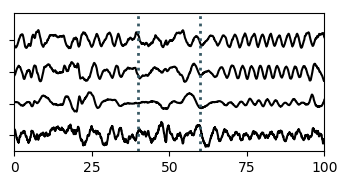

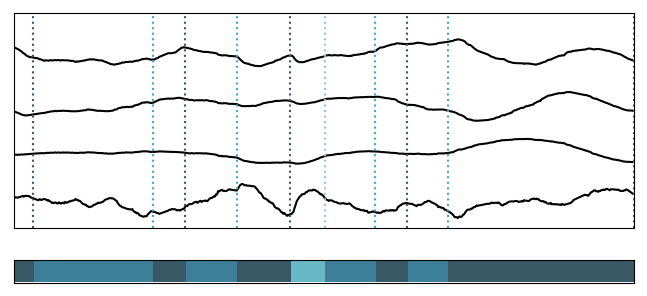

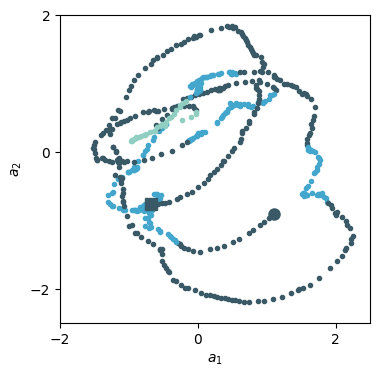

In [22]:
import util_plots as tplot
large_slice = np.arange(0, 3000)
plot_slice = np.arange(1200, 1800)
num_pcs = 4
num_states = 6
mstate , malpha, mgamma, mkappa = num_states, 10, 10, 10**10
models = load_batch_results(experiments_out,"samples",['all'],[mstate],[malpha],[mgamma],[mkappa])
fig1c(models[0],all_aus,large_slice,plot_slice,worm_idx=2)

In [23]:
from scipy.stats import multivariate_normal

cte_train = 0.7
num_pcs = 4

origin_aus = np.vstack(all_aus[:,:num_pcs,:])
_, num_points = origin_aus.shape
num_train = int(cte_train*num_points)
num_test = num_points - num_train
test_aus = origin_aus[:,num_train:]

mus = test_aus.mean(1)
stds = np.cov(test_aus)
Y2 = multivariate_normal(mean=mus,cov=stds)
reference = Y2.logpdf(test_aus.T)

In [24]:
def fig2a (kappa_array,state_array,experiments_out,reference):
    # Given reference
    start_point, end_point= 500, 1000
    num_points = end_point-start_point

    # Choose specific hyperparams
    malpha, mgamma, mkappa = 10.0, 10.0, kappa_array[-1]
    num_states= len(state_array)
    out_bx = np.zeros((num_states,num_points))
    for ii, state in enumerate(state_array):
        cr = load_batch_results(experiments_out,"predictive_lls",
                                ['all'],[state],
                                [malpha],[mgamma],[mkappa])
        ll_out = cr.T[start_point:end_point] - reference.sum()
        out_bx[ii,:]=ll_out.flatten()/num_test

    pll_means, pll_std = out_bx.mean(1),out_bx.std(1)
    index = np.arange(len(out_bx))

    fig = plt.figure(figsize=(5,4))
    ax = fig.add_subplot('111',facecolor='w')
    ax.plot(index,pll_means,ls='-',lw=2,marker='o',color='k')

    ax.set_xticks(index)
    ax.set_xticklabels(map(str,state_array))
    ax.set_yticks(np.linspace(90,120,4))
    ax.set_ylim([90,120])
    ax.set_ylabel('mean PLL')
    ax.set_xlabel('Number of states')
    plt.tight_layout()
    plt.show()
    return

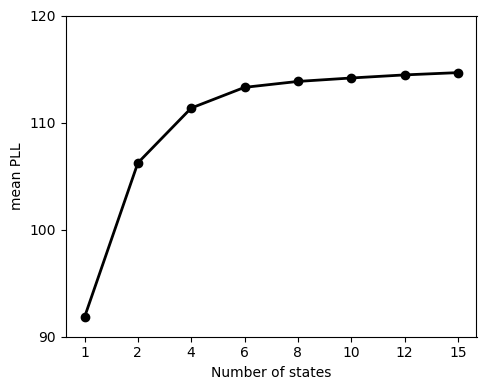

In [25]:
fig2a (kappa_array,state_array,experiments_out,reference)

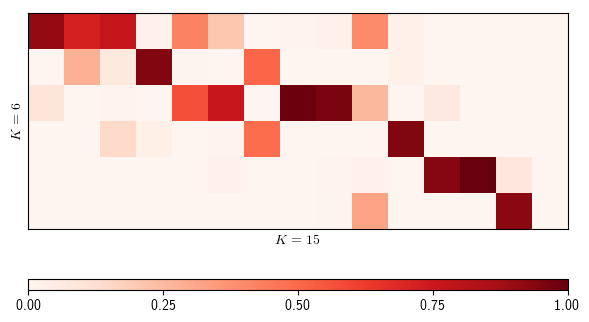

In [29]:
def fig2b(worm_idx,dim1=6,dim2=15):
    malpha, mgamma, mkappa = 10.0, 10.0, 10**10.0
    dim1 , dim2 = 6, 15
    model1 = load_batch_results(experiments_out,"samples",['all'],[dim1],[malpha],[mgamma],[mkappa])[0]
    model2 = load_batch_results(experiments_out,"samples",['all'],[dim2],[malpha],[mgamma],[mkappa])[0]
    z1, perm1 = tplot.relabel_model_z(model1,index=worm_idx,plot_en=False)
    z2, perm2 = tplot.relabel_model_z(model2,index=worm_idx,plot_en=False)
    tplot.state_correlation(z1,z2)
    #plt.savefig('figures/states_labeled_6_vs_15_kappa10_10.svg')
    plt.show()
    return
worm_idx = 2
fig2b(worm_idx)

In [30]:
# given reference

def fig2c(experiments_out,kappa_array,reference):
    start_point , end_point =500 , 1000
    num_points = end_point-start_point

    # Choose specific hyper
    c_state = 6
    malpha, mgamma = 10.0, 10.0
    
    out_bx = np.zeros((len(kappa_array),num_points))
    for ii, mkappa in enumerate(kappa_array):
        cr = load_batch_results(experiments_out,
                                "predictive_lls",['all'],[c_state],
                                [malpha],[mgamma],[mkappa])
        ll_out = cr.T[start_point:end_point] - reference.sum()
        out_bx[ii,:]=ll_out.flatten()/num_test
        
    float_formatter = lambda x: "%.e" % x
    pll_means, pll_std = out_bx.mean(1),out_bx.std(1)
    index = np.arange(out_bx.shape[0])

    fig = plt.figure(figsize=(5,4))
    ax = fig.add_subplot('111',facecolor='w')
    ax.semilogx(kappa_array,pll_means,ls='-',
                lw=2,marker='o',color='k')

    ax.set_xticks(kappa_array)
    ax.set_xticklabels(list(map(float_formatter,kappa_array)))
    ax.set_xlabel(r'$\kappa$')
    ax.set_title(r'PLL for $K=%d$'%6)
    ax.set_yticks(np.linspace(90,120,4))
    ax.set_ylim((90,120))
    plt.tight_layout()
    #plt.savefig('figures/mpll_K6_vs_kappa.svg')
    plt.show()
    return

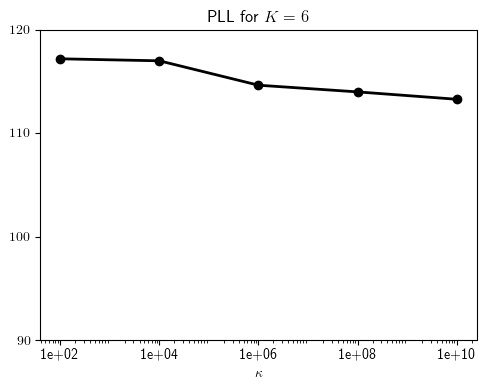

In [31]:
fig2c(experiments_out,kappa_array,reference)

In [32]:
def fig2d(worm_files,kappa_array,experiments_out,worm_idx = 2):
    bins = np.linspace(0, 200, 40)
    dr_all = []
    from pyhsmm.util.general import rle
    malpha, mgamma = 10.0, 10.0
    for mkappa in kappa_array:
        model1 = load_batch_results(experiments_out,"samples",['all'],[6],
                                    [malpha],[mgamma],[mkappa])[0]
        z1, perm1 = tplot.relabel_model_z(model1,index=worm_idx,plot_en=False)
        state_seq, durations = rle(z1)
        dr_ = durations[state_seq==4]
        dr_all.append(dr_)

    ## apend Yemini
    f = h5py.File(os.path.join(dir_dataraw,worm_files[worm_idx]),'r')
    fps = f['info']['video']['resolution']['fps'][0][0]
    
    dr_all.append(durations[state_seq==0])
    frames_len = dr_all[-1]/fps
    

    float_formatter = lambda x: "%.e" %x
    
    fig = plt.figure(figsize=(6,4))
    current_palette = sns.color_palette('Greys',20)
    sns.set_palette(current_palette)
    ax = sns.violinplot(data=dr_all, pallete=None, split=True,scale='width',
                        orient='v',scale_hue=False)

    x_labels=list(map(float_formatter,kappa_array))
    x_labels.append(r'Labeled'+'\n'+'data')
    ax.set_xticklabels(x_labels)
    ax.set_xlabel(r'$\kappa$')

    ylabels= np.linspace(0,frames_len.max(),3,dtype=int)
    ax.set_yticks(ylabels*fps)
    ax.set_yticklabels(list(map(str,ylabels)))

    [t.set_color(i) for (i,t) in
     zip(['k']*(len(kappa_array))+['r'],ax.xaxis.get_ticklabels())]

    plt.tight_layout()
    plt.show()
    return 
    #plt.savefig('figures/pd_rest_state_duration_vs_kappa_violin.svg')

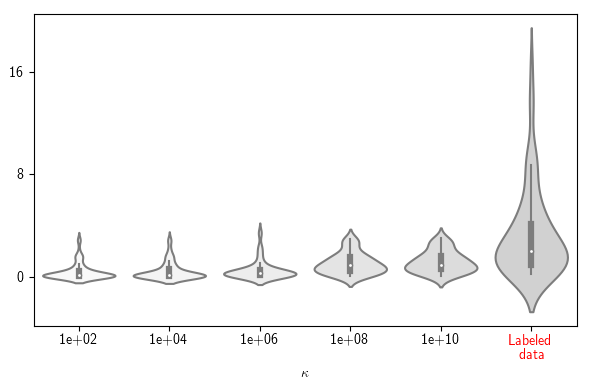

In [33]:
fig2d(worm_files,kappa_array,experiments_out,worm_idx = 2)

In [39]:
def fig3(worm_modes_new,model, xt, index=0, num_pcs=4, 
         num_states=4,color_array=None,vel=False,dsample=50,
         forced_order=[3,1,0,2,4]):
    """
    """
    import math
    
    from matplotlib import rc, rcParams
    import matplotlib
    plt.rc('text', usetex=True)
    plt.rc('font', family='times')
    rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
    matplotlib.rcParams.update({'font.size': 20})
    
    z, perm = tplot.relabel_model_z(model,index=index)
    usages_perm = model.state_usages[perm]
    dynamics_distns = [model.obs_distns[p] for p in perm]
    num_comb_pcs =  int(math.factorial(num_pcs)/(math.factorial(2)*math.factorial(num_pcs-2)))
    fig, ax = plt.subplots(2,num_states-1,figsize=((num_states-1)*2,4));

    if color_array is None:
        color_array = model._get_colors()

    state_names = ['Fwd 1','Fwd 2','Fwd 3','Rest','Rev']
    # manually swapping states so that forward, backward and rest states are adjacent.
    for ii, state in enumerate(forced_order):#[3,1,0,5,2,4]):
        D_latent = dynamics_distns[state].D_out
        Ak = dynamics_distns[state].A[:,:D_latent]
        bk = dynamics_distns[state].A[:,D_latent:]
        x_t = xt[:,np.where(z==state)[0]]
        mu_tp1 = Ak.T.dot(x_t) + bk - x_t

        if vel:
            color_vel = color_array[np.where(z==state)[0]]
       # downsample
        if (x_t.shape[1]>dsample):
            dwr = int(x_t.shape[1] / dsample)
            print ('state {}: downsample by {} from {} steps'.format(
                state,dwr,x_t.shape[1] ))
            x_t = x_t[:,::dwr]
            mu_tp1 = mu_tp1[:,::dwr]
            print('state {} : {} steps'.format(state,x_t.shape[1]))
            if vel:
                color_vel = color_vel[::dwr]
            
            if x_t.shape[1] > dsample:
                x_t = x_t[:,:dsample]
                mu_tp1 = mu_tp1[:,:dsample]
                print('state {} : Selecting {} steps'.format(state,x_t.shape[1]))
                if vel:
                    color_vel = color_vel[:dsample]               
        else:
            print('state {} : {} steps'.format(state,x_t.shape[1]))
        
        for cpair , pair in enumerate([(0,1)]):
            i, j = pair 
            x_t_i,x_t_j =x_t[i,:],x_t[j,:]
            mu_tp1_i, mu_tp1_j=mu_tp1[i,:], mu_tp1[j,:]
            if vel :
                print('see original code')
            else:
                ax[cpair,ii].quiver(x_t_i,x_t_j,mu_tp1_i,mu_tp1_j,alpha=0.5, \
                        headwidth=4., headlength=5., headaxislength=3.5, scale=1.5, \
                                   color=color_array[state],lw=10.0,\
                                  width = 0.015)

            if cpair ==0:
                ax[cpair,ii].set_title('%s'%(state_names[ii]))
            
            x_y_lim = np.linspace(-2,2,3)
            ax[cpair,ii].set_ylim((-2.5,2.5))
            ax[cpair,ii].set_xlim((-2.5,2.5))
            ax[cpair,ii].set_xticks(x_y_lim)
            ax[cpair,ii].set_yticks(x_y_lim)
        # Reference
        c_state_pos = np.argwhere(z==state)
        worms_pos = worm_modes_new[c_state_pos]
        ax[1,ii].hist(worms_pos[~np.isnan(worms_pos)],bins=[-1,0,1,2],align='left',
                       normed=True,facecolor='gray', edgecolor='k',rwidth=0.8)
        ax[1,ii].set_xticks([-1,0,1])
        ax[1,ii].set_xticklabels(['rev','rest','fwd'])
        ax[1,ii].set_ylim(0,1)
        
        if ii > 0:
            for arx in np.arange(2):
                ax[arx,ii].set_yticklabels([])
        plt.subplots_adjust(hspace=0.3)
        plt.tight_layout()
    plt.show()
    return

In [40]:
worm_idx = 2
f = h5py.File(os.path.join(dir_dataraw,worm_files[worm_idx]),'r')
worm_modes= f['worm']['locomotion']['motion']['mode'][()]
worm_modes_new = worm_modes.copy().flatten()

state 3: downsample by 21 from 1087 steps
state 3 : 52 steps
state 3 : Selecting 50 steps
state 1: downsample by 69 from 3465 steps
state 1 : 51 steps
state 1 : Selecting 50 steps
state 0: downsample by 138 from 6928 steps
state 0 : 51 steps
state 0 : Selecting 50 steps
state 2: downsample by 120 from 6049 steps
state 2 : 51 steps
state 2 : Selecting 50 steps
state 4: downsample by 24 from 1245 steps
state 4 : 52 steps
state 4 : Selecting 50 steps


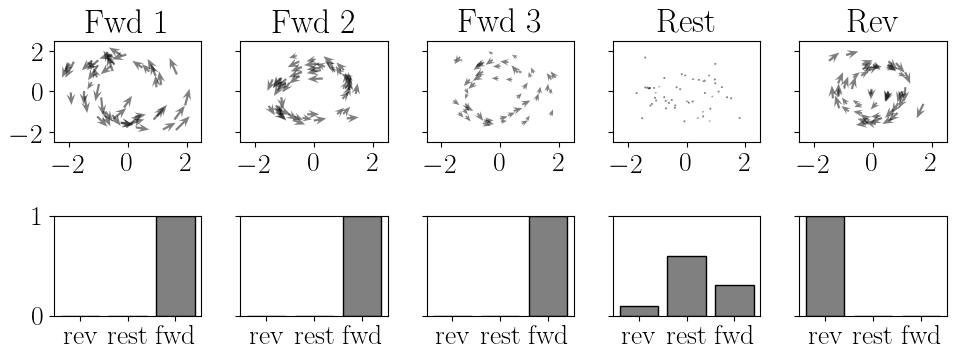

In [41]:
# Make State dynamics plot
import matplotlib._color_data as mcd
aus = all_aus[worm_idx][:num_pcs,:18894]
fig3(worm_modes_new,models[0], aus, index=worm_idx, num_pcs=4, num_states=6,
     color_array=['k']*6,vel=False)

In [37]:
def fig4(model,perm):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    C_plot = model.trans_distn.trans_matrix.copy()
    C_plot2 = C_plot/C_plot.sum(1,keepdims=True)
    
    fig = plt.figure()
    ax = fig.add_subplot('111')
    state_names = ['Fwd$_{1}$','Fwd$_{2}$','Fwd$_{3}$','Rest$_{\,}$','Rev$_ $']

    # State transitions
    C_plot = model.trans_distn.trans_matrix.copy()
    np.fill_diagonal(C_plot,0)
    # manually swapping states so that forward, backward and rest states are adjacent.
    vals_=perm[[[3,1,0,2,4]]] #[3,1,0,5,2,4]]]
    C_plot = C_plot / C_plot.sum(1,keepdims=True)
    im = ax.imshow(C_plot[np.ix_(vals_,vals_)],
                   cmap='Reds',vmin=0,vmax=C_plot.max())
    ax.set_xticks(np.arange(5))
    ax.set_yticks(np.arange(5))

    ax.set_xticklabels(state_names,va='top')
    ax.set_yticklabels(state_names,ha='right')

    ax.set_ylabel(r'$z_{t}$')
    ax.set_xlabel(r'$z_{t+1}$')
    divider = make_axes_locatable(ax)

    cax = divider.append_axes('bottom',size='5%',pad=0.6)
    cbar = plt.colorbar(im,cax=cax,orientation='horizontal',format='%.2f',\
                       ticks=np.linspace(0,C_plot.max(),3))
    cbar.ax.set_yticklabels(np.linspace(0,C_plot.max(),3))
    plt.tight_layout()
    plt.show()
    return

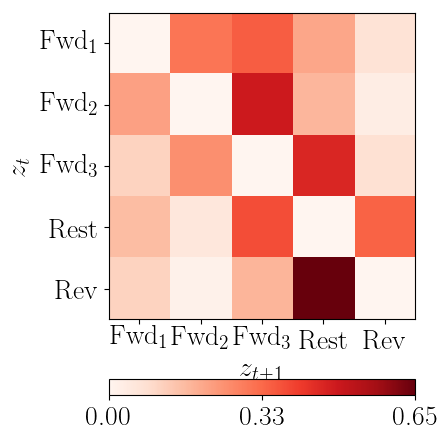

In [38]:
z, perm = tplot.relabel_model_z(models[0],index=worm_idx)
fig4(models[0],perm)